In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from scipy import optimize

import tensorflow as tf
import torch
import os
os.chdir('..')

In [2]:
tickers = ['aapl', 'amd', 'msft', 'intc', 'd', 'sbux', 'atvi',
          'ibm', 'ual', 'vrsn', 't', 'mcd', 'vz']

In [31]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) 
        for x in dir() if not x.startswith('_') 
        and x not in sys.modules and x not in ipython_vars], 
       key=lambda x: x[1], reverse=True)

In [4]:
etf_path = 'iexfinance/Data/ETFs/{}.us.txt'
stock_path = 'iexfinance/Data/Stocks/{}.us.txt'

def read_csv(ticker, is_etf=False):
    path = etf_path.format(ticker) if is_etf else stock_path.format(ticker)
    cur_df = pd.read_csv(path)
    cur_df.drop(['Volume', "OpenInt"], axis=1, inplace=True)
    return cur_df

In [5]:
spy = read_csv('spy', True)
spy_default = spy.copy()
for ticker in tickers:
    ticker_df = read_csv(ticker)
    spy_default = pd.merge(spy_default, 
                           ticker_df, 
                           on='Date', 
                           how='left', 
                           suffixes=('', '_'+ticker))
    

In [6]:
def give_delta_historical(df):
    original_col = df.columns[1:]
    
    # shift days
    for shift_idx in [3, 5, 10, 20, 40]:
        for col in original_col:
            df[col+'_'+str(shift_idx)] = df[col].shift(shift_idx)
    
    # np.log all values
    for item in df:
        if np.issubdtype(df[item].dtype, np.number):
            df[item] = np.log(df[item])
    
    df_values = df.values
    # for lookback
    for row_idx in range(5, df_values.shape[1], 4):
        df_values[:, row_idx:row_idx+4] = df_values[:, 1:5] - \
                                           df_values[:, row_idx:row_idx+4]
    # for today
    for idx in range(len(df_values)-1, 0, -1):
        df_values[idx, 1:5] -= df_values[idx-1, 1:5]
    
    return df_values

In [7]:
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [8]:
spy = read_csv('spy', True)
spy_original = read_csv('spy', True)

spy_from_fn = give_delta_historical(spy)
# x:= revised val, y:= original.shift(-1)
print(spy_from_fn.shape, spy_original.shape)
# Drop NaN here
spy_from_fn = spy_from_fn[40:]
print(spy_from_fn.shape, spy_original.shape)

(3201, 25) (3201, 5)
(3161, 25) (3201, 5)


In [32]:
def process_output_data(spy_original):
    original_columns = spy_original.columns[1:]
    # shift 10, 5
    for col in original_columns:
        spy_original['10_'+str(col)] = spy_original[col].shift(-10)
    for col in original_columns:
        spy_original['5_'+str(col)] = spy_original[col].shift(-5)
    # log_delta
    for col in original_columns:
        spy_original['10_'+col] = np.log(spy_original['10_'+col].values) - \
                                  np.log(spy_original[col].values)
    for col in original_columns:
        spy_original['5_'+col] = np.log(spy_original['5_'+col].values) - \
                                 np.log(spy_original[col].values)
    return spy_original

In [9]:
# original_columns = spy_original.columns[1:]
# # shift 10, 5
# for col in original_columns:
#     spy_original['10_'+str(col)] = spy_original[col].shift(-10)
# for col in original_columns:
#     spy_original['5_'+str(col)] = spy_original[col].shift(-5)
# # log_delta
# for col in original_columns:
#     spy_original['10_'+col] = np.log(spy_original['10_'+col].values) - \
#                               np.log(spy_original[col].values)
# for col in original_columns:
#     spy_original['5_'+col] = np.log(spy_original['5_'+col].values) - \
#                               np.log(spy_original[col].values)
spy_original = process_output_data(spy_original)

In [10]:
Y = spy_original['10_Open'][40:]
print('X.shape: {}, Y.shape: {}'.format(spy_from_fn.shape, Y.shape))
print('Indecies of NaN in Y:\n {}'.format(np.argwhere(Y.isna())))
print('Drop those rows ...')
delete_from_back = Y.isna().sum()
spy_from_fn = spy_from_fn[:-delete_from_back]
Y = Y[:-delete_from_back].values
# Y = Y.reshape(-1, 1)
print('X.shape: {}, Y.shape: {}'.format(spy_from_fn.shape, Y.shape))

X.shape: (3161, 25), Y.shape: (3161,)
Indecies of NaN in Y:
 [[3151]
 [3152]
 [3153]
 [3154]
 [3155]
 [3156]
 [3157]
 [3158]
 [3159]
 [3160]]
Drop those rows ...
X.shape: (3151, 25), Y.shape: (3151,)


In [11]:
spy_from_fn[:, 1:] = spy_from_fn[:, 1:].astype(np.float64)

In [12]:
# y_standard_scaler = StandardScaler()
# y = y_standard_scaler.fit_transform(Y)

In [13]:
X = spy_from_fn[:, [1, 4*3+1]]

distributions = [
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
]

/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/wbaik/.conda/envs/clone_tf/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
cmap = getattr(cm, 'plasma_r', cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)

In [23]:
def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    
    ax.scatter(X[:, 0], X[:, 1], 
               alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], 
                 bins=hist_nbins, 
                 orientation='horizontal',
                 color='grey',
                 ec='grey')
    hist_X1.axis('off')

    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], 
                 bins=hist_nbins, 
                 orientation='vertical',
                 color='grey',
                 ec='grey')
    hist_X0.axis('off')

In [28]:
def make_plot(item_idx, y_unscaled, y_scaled):
    assert y_scaled.ndim <= 2, 'y.ndim : {}'.format(
                                        y_scaled.ndim)
    assert y_unscaled.ndim <= 2, 'y.ndim : {}'.format(
                                        y_unscaled.ndim)
    if y_scaled.ndim == 2: 
        y_scaled = y_scaled.flatten()
    if y_unscaled.ndim == 2: 
        y_unscaled = y_unscaled.flatten()
    
    title, X = distributions[item_idx]
    
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    
    plot_distribution(axarr[0], X, y_scaled, hist_nbins=200,
                      x0_label="X_0",
                      x1_label="X_1",
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], 
                      X[non_outliers_mask], 
                      y_scaled[non_outliers_mask],
                      hist_nbins=50,
                      x0_label="X_0",
                      x1_label="X_1",
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_unscaled.min(), y_unscaled.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')

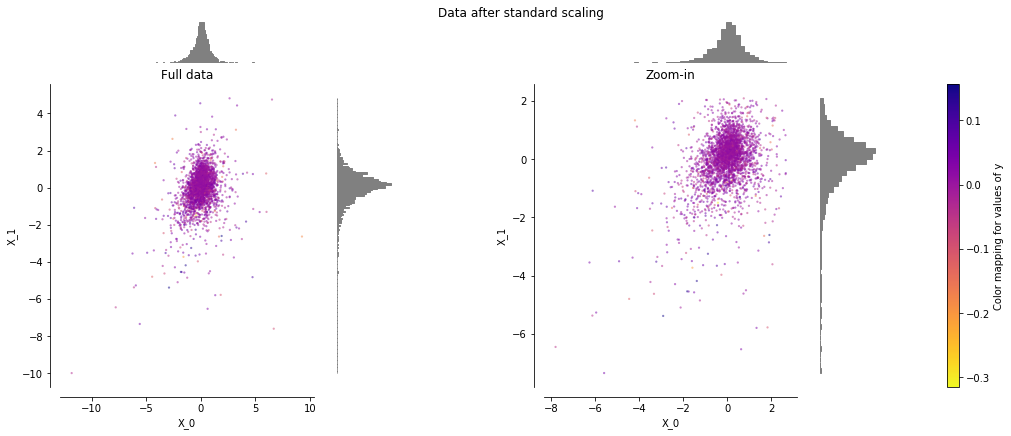

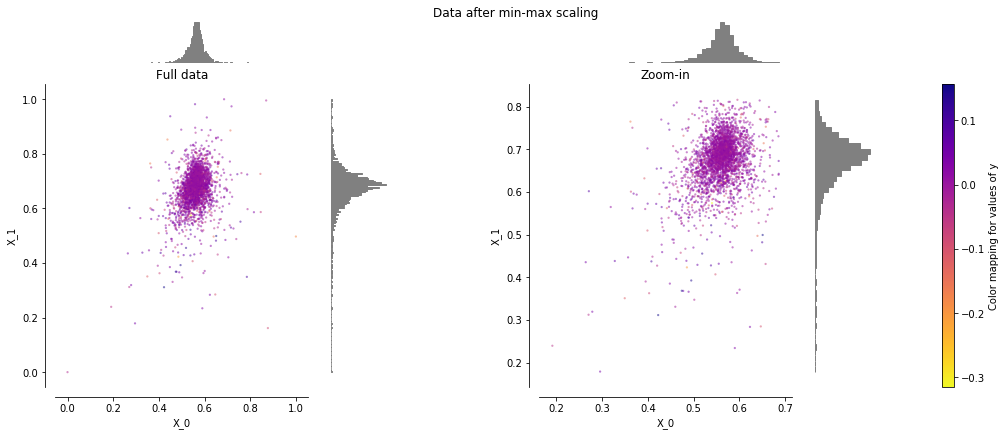

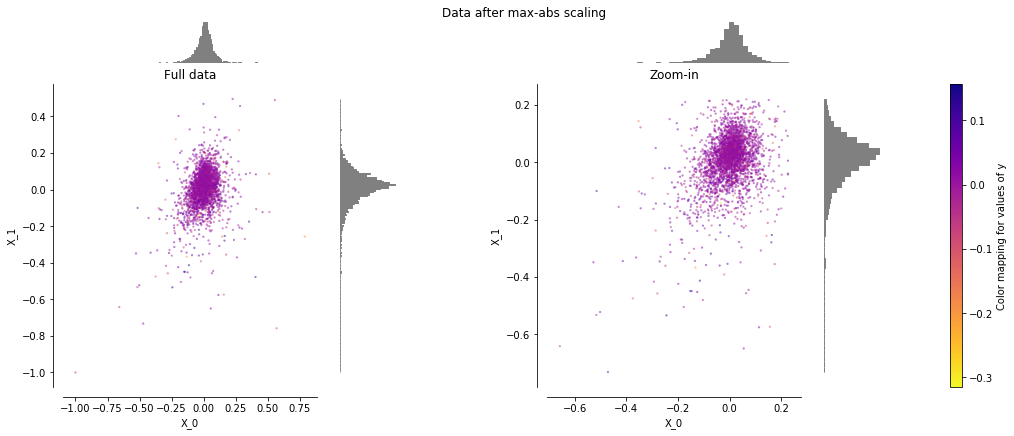

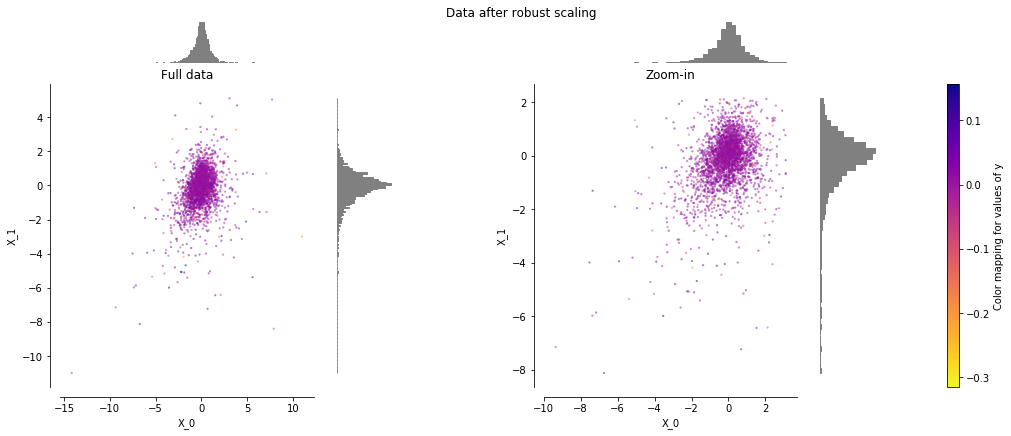

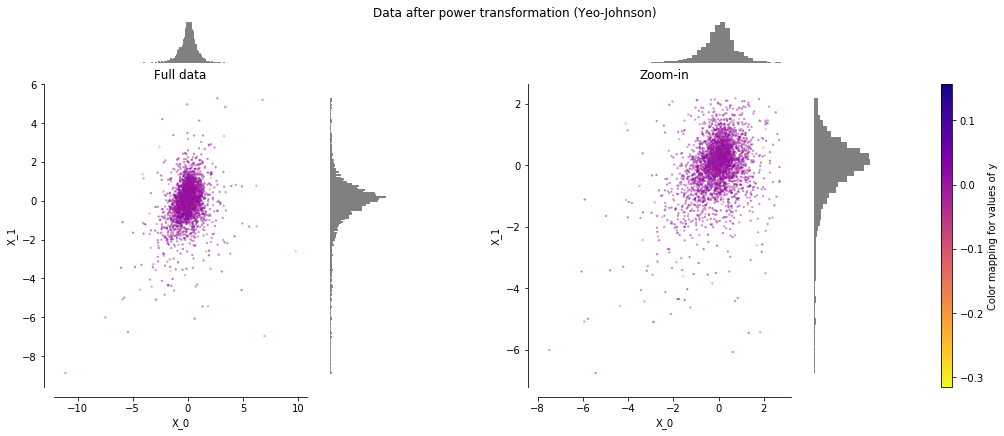

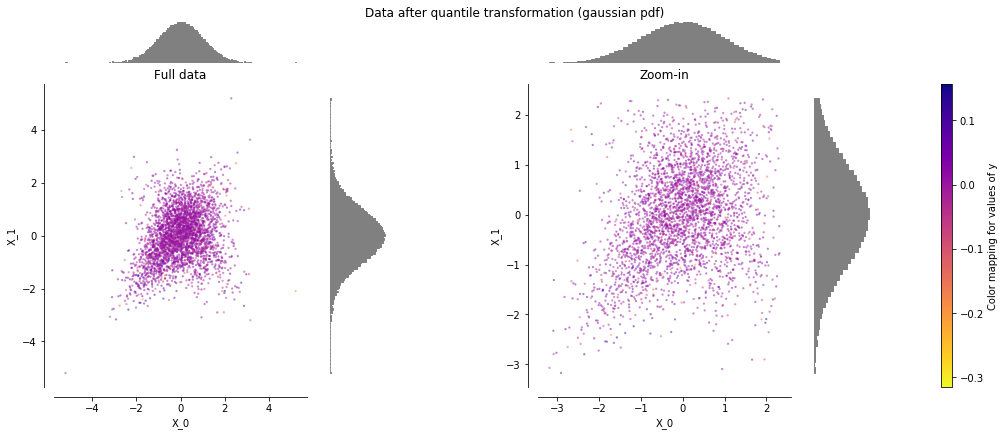

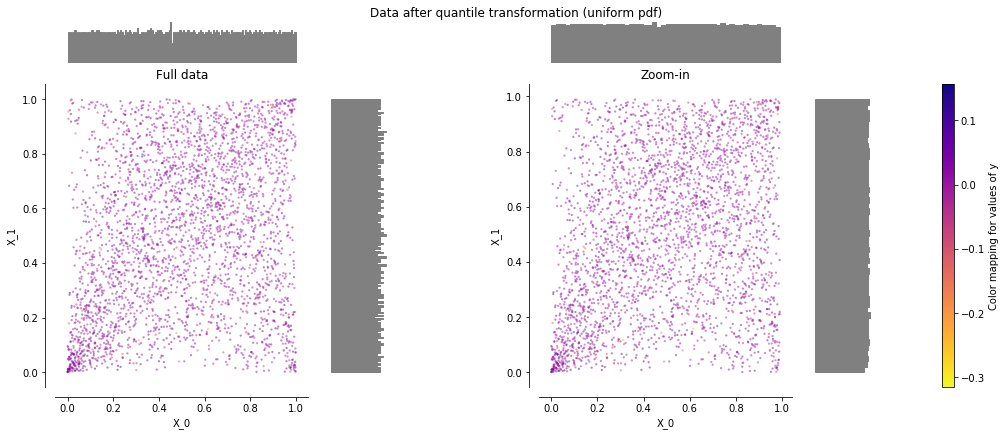

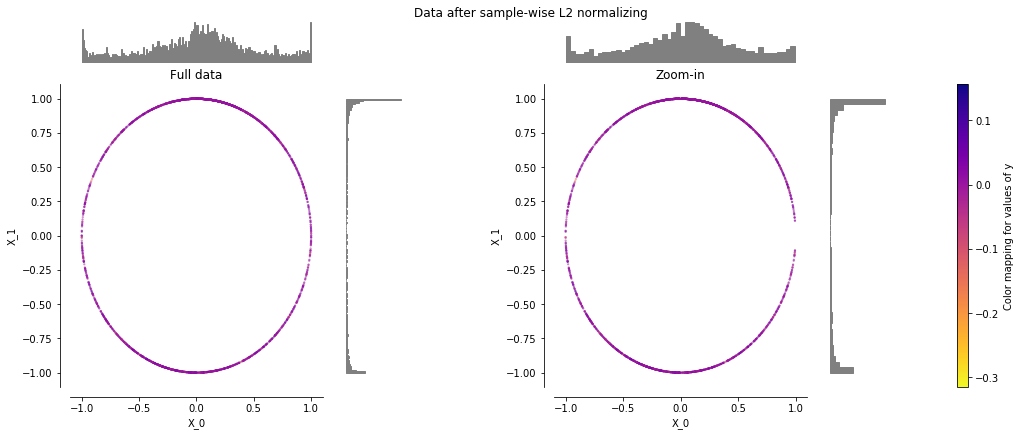

In [29]:
y = minmax_scale(Y)
for idx in range(len(distributions)):
    make_plot(idx, y_unscaled=Y, y_scaled=y)